In [1]:
!pip install -U -q PyDrive

In [ ]:
import numpy as np
import random
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import copy
from time import time
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
folder = 'Folder_id'
file_list = drive.ListFile({'q':f"'{folder}' in parents and trashed=false"}).GetList()
for index, f in enumerate(file_list):
  f.GetContentFile(f['title'])

In [ ]:
class Activation(object):
    # relu activation function
    def __relu(self, x):
      return np.maximum(0, x)
    
    # relu function derivative 
    def __relu_deriv(self, a):
      return np.greater(a, 0).astype(float)

    def __tanh(self, x):
        return np.tanh(x)

    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    
    def __init__(self, activation='relu'):
        if activation == "relu":
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv


class Dropout:
    def __init__(self, p=0.5):
        if not 0 <= p <= 1:
            raise ValueError("Dropout probability must be in range [0, 1].")
        self.p = p # probability of dropping a unit
        self.mask = None

    def forward(self, X, training=True):
        # if p=0, no Dropout
        if self.p == 0:
            return X
        # if p=1, all units are dropped
        elif self.p == 1:
            return np.zeros_like(X)
        
        if training:
            # generate a binomial distributed metric, and divide the prob to maintain the Expectation
            self.mask = np.random.binomial(1, 1 - self.p, X.shape) / (1 - self.p)
            return X * self.mask
        else:
            # if not training, no dropout
            return X
        
    def backward(self, dX):
        if self.p == 0:
            return dX
        elif self.p == 1:
            return np.zeros_like(dX)
        else:
            return dX * self.mask


class SoftmaxCrossEntropy:
    def __init__(self):
        pass
    
    
    def forward(self, X_prev, y_true):
        # calculate softmax
        # X_prev = X_prev - np.max(X_prev, axis=-1, keepdims=True)
        exp_X_prev = np.exp(X_prev)

        # calculate y_pred 
        y_pred = exp_X_prev / np.sum(exp_X_prev, axis=-1, keepdims=True)

        # calculate cross-entropy
        n_samples = X_prev.shape[0]

        # get the position of each probability according to output
        log_likelihood = -np.log(y_pred[np.arange(n_samples), y_true])

        # average the loss
        loss = np.sum(log_likelihood) / n_samples

        return y_pred, loss
    
    def backward(self, y_pred, y_true):
        n_samples = y_pred.shape[0]
        y_true_one_hot = np.zeros_like(y_pred)

        # set the position of label to 1, otherwise 0
        y_true_one_hot[np.arange(n_samples), y_true] = 1

        # calculate gradient
        gradients = (y_pred - y_true_one_hot) / n_samples

        return gradients


class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=0.0):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.momentum = 0
        self.t = 0
        self.module = 'Adam'

    def load(self, layers):
        self.layers = layers
        self.m_W = [np.zeros_like(layer.W) for layer in layers]
        self.m_b = [np.zeros_like(layer.b) for layer in layers]
        self.v_W = [np.zeros_like(layer.W) for layer in layers]
        self.v_b = [np.zeros_like(layer.b) for layer in layers]

    def step(self):
        self.t += 1
        for i, layer in enumerate(self.layers):
            grad_W = layer.grad_W
            grad_b = layer.grad_b
            # Engineer approach - weight decay
            if self.weight_decay > 0:
                grad_W = grad_W + self.weight_decay * layer.W
                grad_b = grad_b + self.weight_decay * layer.b
            # Computing mt and vt and their bias
            self.m_W[i] = self.beta1 * self.m_W[i] + (1 - self.beta1) * grad_W
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * grad_b
            self.v_W[i] = self.beta2 * self.v_W[i] + (1 - self.beta2) * np.square(grad_W)
            self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * np.square(grad_b)
            # Computing unbiased mt and vt
            m_hat_W = self.m_W[i] / (1 - np.power(self.beta1, self.t))
            m_hat_b = self.m_b[i] / (1 - np.power(self.beta1, self.t))
            v_hat_W = self.v_W[i] / (1 - np.power(self.beta2, self.t))
            v_hat_b = self.v_b[i] / (1 - np.power(self.beta2, self.t))
            # Update 
            layer.W -= self.lr * m_hat_W / (np.sqrt(v_hat_W) + self.epsilon)
            layer.b -= self.lr * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)



class BatchNorm(object):
    def __init__(self, n_out):
        # Initialise learning parameter gamma and beta
        self.gamma = np.ones(n_out,)
        self.beta = np.zeros(n_out,)
        # initialise moving mean and moving variance to 0 
        self.moving_mu = np.zeros(n_out,)
        self.moving_var = np.zeros(n_out,)
        # Initialise momentum and epsilion
        self.momentum = 0.99
        self.eps = 0.001
        

    def batch_forward(self, X, training = True):
        # Check if this is training
        if not training:
            X_hat = (X - self.moving_mu) / np.sqrt(self.moving_var + self.eps)
        else:
            # mini-batch mean
            mu = X.mean(axis = 0)
            # x_mu
            x_mu = X-mu
            # mini-batch variance
            var = ((x_mu)**2).mean(axis = 0)
            # square root of variance and epsilon
            sqrt_var = np.sqrt(var + self.eps)
            # normalise
            X_hat = (X - mu) / sqrt_var
            # Updating the moving mean and variance using exponential decay method
            self.moving_mu = self.moving_mu * self.momentum + (1.0 - self.momentum) * mu 
            self.moving_var = self.moving_var * self.momentum  + (1.0 - self.momentum) * var
            # cache for storing parameters
            self.cache = (x_mu, X_hat, var, sqrt_var) 
        
        # Scale and shift
        y = self.gamma * X_hat + self.beta

        return y

    def batch_backward(self, dout):

        #unfold the variables stored in cache
        x_mu, X_hat, var, sqrt_var= self.cache

        #get the dimensions of the ouput
        N,D = dout.shape
        # derivative of xhat
        d_xhat = dout * self.gamma
        #derivative of variance
        d_ivar = np.sum(d_xhat * x_mu, axis=0) 
        d_var = 0.5 * (1. /np.sqrt(var + self.eps)) * (-1. /(sqrt_var**2) * d_ivar)
        d_sq = 1. /N * np.ones((N,D)) * d_var
        # Derivate of delta
        dmu = -1 * np.sum(d_xhat * (1. / sqrt_var)+(2 * x_mu * d_sq), axis=0)
        delta = d_xhat * (1./sqrt_var) + (2 * x_mu * d_sq) + (1./N * np.ones((N,D)) * dmu)
        # Derivative of gamma
        d_gamma = np.sum(dout * X_hat, axis=0)
        # Derivative of beta
        d_beta = np.sum(dout, axis=0)

        return delta, d_gamma, d_beta
    
class SGD():
    def __init__(self, lr, momentum=0.9, weight_decay=0.0):
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.module = 'SGD'

    def load(self, layers):
      self.layers = layers
    
    def step(self):
        for layer in self.layers:
            grad_W = layer.grad_W
            grad_b = layer.grad_b

            # implement weight decay
            if self.weight_decay > 0:
                grad_W = grad_W + self.weight_decay * layer.W
                grad_b = grad_b + self.weight_decay * layer.b

            # Implement SGD momentum
            layer.velocity_W = self.momentum * layer.velocity_W + self.lr * grad_W
            layer.velocity_b = self.momentum * layer.velocity_b + self.lr * grad_b

            # Update layer parameters
            layer.W -= layer.velocity_W
            layer.b -= layer.velocity_b
            # update gammma and beta 
    
class HiddenLayer(object):    
    def __init__(self, n_in, n_out, activation='relu', W=None, b=None, dropout_rate=0.5, is_output=False, batch_norm = None):
        self.input = None
        self.is_output = is_output
        self.batch_norm = batch_norm
        # get the input shape
        self.n_out = n_out
        
        # if not output layer, then only have linear layer
        if not self.is_output:
            self.activation = Activation(activation).f
            self.activation_deriv = Activation(activation).f_deriv
            self.dropout = Dropout(dropout_rate)

        # Kaiming initialization
        self.W = np.random.uniform(low=-np.sqrt(6 / n_in), high=np.sqrt(6 / n_in), size=(n_in, n_out))

        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        
        # we set he size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)

        # Set velocity weight and bias for momentum
        self.velocity_W = np.zeros(self.W.shape)
        self.velocity_b = np.zeros(self.b.shape)

        # Initialize batch normalisation layer
        if self.batch_norm:
            self.batch_norm = BatchNorm(self.n_out)
         
        
    
    # the forward and backward progress (in the hidden layer level) for each training epoch
    def forward(self, input, training=True):
        # linear layer
        self.output = np.dot(input, self.W) + self.b

        # activation layer and dropout layer 
        if not self.is_output:
            self.output = self.dropout.forward(self.activation(self.output), training=True)
        
        # Add batchnorm layer
        if self.batch_norm:
            self.output= self.batch_norm.batch_forward(self.output, training = training)
        
        self.input=input
        return self.output
    

    def backward(self, delta, lr):
        # if not the last layer
        if not self.is_output:
            # Backward pass through the dropout layer
            delta = self.dropout.backward(delta)

            # add batch norm backward
            if self.batch_norm:
                delta, dgamma, dbeta = self.batch_norm.batch_backward(delta)
                self.batch_norm.gamma = self.batch_norm.gamma - lr * dgamma
                self.batch_norm.beta = self.batch_norm.beta - lr * dbeta

            # Calculate the gradient of activation function
            activation_grad = self.activation_deriv(self.output)

            # Multiply the gradient of activation function with the gradient of the next layer
            delta *= activation_grad

        # Calculate gradients for the current layer
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = np.sum(delta, axis=0)
     
        # update delta
        delta = delta.dot(self.W.T)
        

        return delta


class MLP:
    def __init__(self, layers, activation=['relu', 'relu', None], optimizer=SGD(lr=0.01, weight_decay=0.01, momentum=0.9), 
                 batch_size = 128, dropout_rate = 0.5, batch_norm = None):
        self.layers = []
        self.activation = activation

        # Confirm batch size and dropout rate and learning rate
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.optimizer = optimizer

        self.spec = {'layer':layers,'activation':activation,'optimizer':optimizer.module,'learning rate':optimizer.lr,
                     'weight decay':optimizer.weight_decay,'momentum':optimizer.momentum,'dropout rate':dropout_rate,
                     'batch size':batch_size,'batch norm':batch_norm}
        print(self.spec)
        # add all layers
        for i in range(len(layers) - 1):
            layer = HiddenLayer(layers[i], layers[i + 1], activation[i], dropout_rate= self.dropout_rate, batch_norm = batch_norm, 
                                is_output=True if i == (len(layers) - 2) else False)
            self.layers.append(layer)
        
        optimizer.load(self.layers)
        
        # default mode
        self.is_training = True


    # evaluation mode
    def eval(self):
        self.is_training = False

    # training mode
    def train(self):
        self.is_training = True

    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self, input):
        for layer in self.layers:
            output=  layer.forward(input, training=self.is_training)
            input = output
        return output


    def criterion_CrossEntropy(self, X_prev, y_true):
        # Instantiate a SoftmaxCrossEntropy
        softmax_cross_entropy = SoftmaxCrossEntropy()

        # Ensure X_prev is a 2D array
        X_prev = np.atleast_2d(X_prev)

        # forward pass
        y_pred, loss = softmax_cross_entropy.forward(X_prev, y_true)

        # backward pass
        delta = softmax_cross_entropy.backward(y_pred, y_true)

        return loss, delta


    # backward progress  
    def backward(self,delta, lr):
        for layer in reversed(self.layers):
            delta = layer.backward(delta, lr)


    # update the network weights after backward.   
    def update(self):
        self.optimizer.step()


    def fit(self, X, y, X_val, y_val, epochs=100):

        X = np.array(X)
        y = np.array(y)
        best_val_acc = 0
        best_k = 0
        log = []

        for k in range(epochs):
            loss = np.zeros(X.shape[0])
            epoch_log = {'epoch':0,'train loss':0,'train acc':0,'val acc':0, 'best index':0}
            for it in range(X.shape[0]//self.batch_size):
                self.is_training = True
                # Random sample mini batch
                i = random.sample(range(X.shape[0]), self.batch_size)  

                # forward pass
                y_hat = self.forward(X[i])

                # compute loss and delta using criterion_CrossEntropy
                loss[it], delta = self.criterion_CrossEntropy(y_hat, y[i].reshape(self.batch_size,))

                # backward pass
                self.backward(delta, lr = self.optimizer.lr)

                # update
                self.update()

            # test on validation set
            self.is_training = False
            y_train_pred = np.argmax(self.predict(X_train), axis=1)
            train_acc = accuracy_score(y_train, y_train_pred)

            y_val_pred = np.argmax(self.predict(X_val), axis=1)
            val_acc = accuracy_score(y_val, y_val_pred)
            # save the model with the highest validation accuracy
            if val_acc > best_val_acc:
              best_val_acc = val_acc
              best_model = copy.deepcopy(self)
              best_k = k
              
            epoch_log['best index'] = best_k
            epoch_log['epoch'] = k
            epoch_log['train loss'] = np.mean(loss)
            epoch_log['train acc'] = train_acc
            epoch_log['val acc'] = val_acc
            
            log.append(epoch_log)

        return log, best_model


    def predict(self, x):
        x = np.array(x)
        output = np.zeros((x.shape[0], self.layers[-1].b.shape[0]))
        for i in np.arange(x.shape[0]):
            output[i] = self.forward(x[i, :])
        return output

# This is a helper function for hyperparameter tunning which just 
# repeat training and evaluation process several times depending on the input
def test_model(layers = [128, 64, 32, 10], activation = ['relu', 'relu', None], 
               optimizer = [Adam(lr=0.01, weight_decay=0.01)],
               batch_size=[128], batch_norm=True, dropout_rate=[0], epochs=10):
  
  losses = []
  final_accs = []
  best_accs = []
  times = []
  for opt in optimizer:
    for bs in batch_size:
      for dr in dropout_rate:
        time_start = time()
        mlp = MLP(layers=layers, activation=activation, optimizer=opt, batch_size = bs,
          batch_norm=batch_norm, dropout_rate=dr)
        mlp.train()
        loss_history, best_model = mlp.fit(X_train, y_train, X_val, y_val, epochs=epochs)
        losses.append(loss_history)
        mlp.eval()
        y_pred = np.argmax(mlp.predict(X_test), axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        final_accs.append(accuracy)
        print(f"Test accuracy of training model: {accuracy * 100:.3f}%")
        time_training = (time() - time_start)
        times.append(time_training)
        best_model.eval()
        y_pred = np.argmax(best_model.predict(X_test), axis=1)
        accuracy = accuracy_score(y_test, y_pred)
        best_accs.append(accuracy)
        print(f"Test accuracy of the best model: {accuracy * 100:.3f}%")     
        print(f"Time of training process: {time_training:.3f}%")

  return losses, best_accs

# Prepare log data for plotting
def untangle_log(logs):

  list_train_acc = []
  list_val_acc = []
  list_train_loss = []
  list_index = []
  for log in logs:
    list_train_acc.append(log['train acc'])
    list_train_loss.append(log['train loss'])
    list_val_acc.append(log['val acc'])
    list_index.append(log['best index'])

  return   list_train_acc, list_val_acc, list_train_loss, list_index


In [ ]:
# Load and shuffle data
X_train = np.load("train_data.npy")
y_train = np.load("train_label.npy")
X_test = np.load("test_data.npy")
y_test = np.load("test_label.npy")

X = np.concatenate((X_train,X_test),axis=0)
y = np.concatenate((y_train,y_test),axis=0)
indices = list(range(0,X.shape[0]))

# Shuffle data and extract train, validation and test with
# the ratio of 80%, 10% and 10%
random.shuffle(indices)
train_indices = indices[:int(X.shape[0]*0.8)]
val_indices = indices[int(X.shape[0]*0.8):int(X.shape[0]*0.9)]
test_indices = indices[int(X.shape[0]*0.9):]

X_train, X_val, X_test, y_train, y_val, y_test = ([] for i in range(0,6))


for i in train_indices:
  X_train.append(X[i])
  y_train.append(y[i])

for i in val_indices:
  X_val.append(X[i])
  y_val.append(y[i])

for i in test_indices:
  X_test.append(X[i])
  y_test.append(y[i])

In [ ]:
# Code instruction

# Define the neural network architecture
layers = [128, 64, 32, 10]
# Define activation functions for each layer
activation = ['relu', 'relu', None]
# Define optimizer with learning rate, weight decay rate and momentum (not applicable for Adam).
optimizer_adam = Adam(lr=0.01, weight_decay=0.01)
optimizer_sgd = SGD(lr=0.01, weight_decay=0.01, momentum=0.9)
# Initialize the MLP model with batch size is 256, batch normalization is enabled, dropout rate is 0 (disabled).
mlp = MLP(layers=layers, activation=activation, optimizer=optimizer_adam, batch_size = 256,
          batch_norm=True, dropout_rate=0)
# Set model to training mode
mlp.train()
time_start = time()
epoch = 50
# Train the MLP
logs, best_model = mlp.fit(X_train, y_train, X_val, y_val, epochs=epoch)
time_training = (time() - time_start)
# Set model to evaluation model
mlp.eval()
# Predict the class labels with trained model
y_pred = np.argmax(mlp.predict(X_test), axis=1)
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy of training model: {accuracy * 100:.3f}%")
# Perform evaluation with the best model
best_model.eval()
y_pred = np.argmax(best_model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy of the best model: {accuracy * 100:.3f}%")
# Print training time
print(f"Time of training process: {time_training:.3f}s")

{'layer': [128, 64, 32, 10], 'activation': ['relu', 'relu', None], 'optimizer': 'Adam', 'learning rate': 0.01, 'weight decay': 0.01, 'momentum': 0, 'dropout rate': 0, 'batch size': 256, 'batch norm': True}
Test accuracy of training model: 48.617%
Test accuracy of the best model: 49.683%
Time of training process: 160.588s


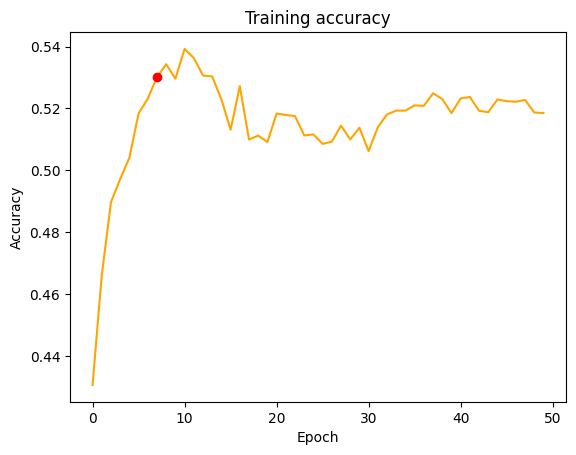

In [ ]:
# Separate log information
train_acc, val_acc, train_loss, index = untangle_log(logs)
# Plot training accuracy (red dot means the epoch we find the best model
# which is the model with the highest validation accuracy)
plt.plot(range(0,epoch),train_acc,color='orange',)
plt.plot(index[-1],train_acc[index[-1]],color='red',marker='o')
plt.title('Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

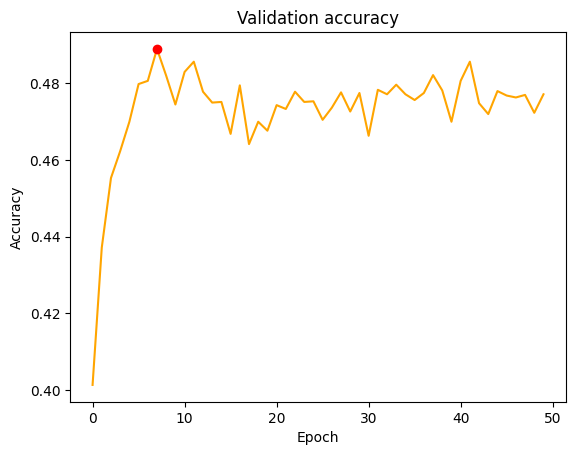

In [ ]:
# Plot validation accuracy
plt.plot(range(0,epoch),val_acc,color='orange',)
plt.plot(index[-1],val_acc[index[-1]],color='red',marker='o')
plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

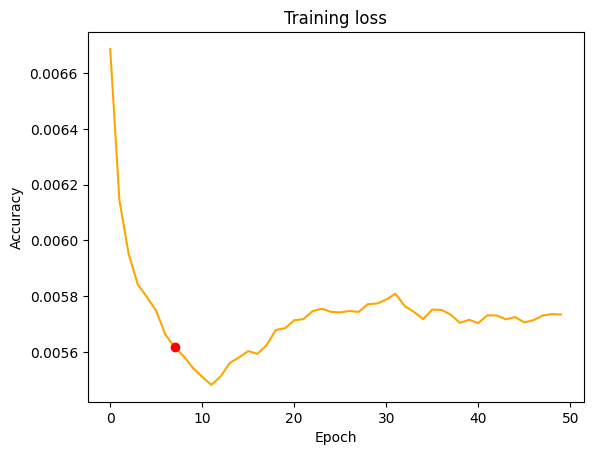

In [ ]:
# Plot training loss
plt.plot(range(0,epoch),train_loss,color='orange',)
plt.plot(index[-1],train_loss[index[-1]],color='red',marker='o')
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()